In [15]:
using Revise

In [1]:
using
    UnitsToValue,
    Printf,
    Plots,
    ImageFiltering
;

include("CaOH_package.jl")
include("helper_functions.jl")
include("analyze_results.jl")
include("load_save_results.jl")
;

[ Info: Precompiling QuantumStates [17f0441f-15e0-42ae-a101-302633ff8f0f]


## Define CaOH Hamiltonian and molecular states

In [2]:
μ_B = 9.2740100783e-24
package = get_CaOH_package(); # loads molecular structure (the states, their energy, Zeeman Hamiltonian, etc)
package_A = package;
# package_A = get_CaOH_package_12_A_states(); # this includes more A states, for calculating AC Stark shift in the ODT.
k = package.k
Γ = package.Γ
m = package.m
;

In [12]:
Δ1, Δ3

(7.599999999999994e6, 5.089999999999996e6)

In [13]:
s1, s3

(2.006884255672135, 2.006884255672135)

## Define experimental parameters

In [3]:
function get_Δ_from_exp(voltage, aom1_freq, aom2_freq)
    # return Δ1, Δ2 in MHz
    Δ1 = 52 - 7.4*(5.5-voltage)
    Δ3 = Δ1 + 51.24 - aom1_freq
    Δ4 = Δ1 + 51.24 - aom2_freq
    return Δ1, Δ3, Δ4
end


## Initial condition of the molecule cloud
temp = @with_unit 0.1 "mK"
diameter = @with_unit 0.6 "mm"
displacement = [0.0, 0.0, 0.0]*1e-3
kick = [0,0, 0.0, 0.0]
 
## Define B field gradient and ramp time
B_gradient = -72 ; ramp_time = 4e-3

## Laser detunings
detuning_voltage = -0.5
aom1_freq = 53.75
aom2_freq = 52
Δ1, Δ3, Δ2 = get_Δ_from_exp(detuning_voltage, aom1_freq, aom2_freq).*(1e6)
Δ4 = 0.0
Δ5 = 0.0


## Laser intensities
intensity_voltage = 0.9
power_total = intensity_voltage * 13.1 /2.2 # mW

r1 = 3.7
r3 = 2.8 
r2 = 3.5 

# r1 = 1
# r3 = 1
# r2 = 0

p1 = r1/(r1+r2+r3) * power_total
p3 = r3/(r1+r2+r3) * power_total
p2 = r2/(r1+r2+r3) * power_total

s1 = 2 * p1 / (π * 0.5^2) / 3.4
s2 = 2 * p2 / (π * 0.5^2) / 3.4
s3 = 2 * p3 / (π * 0.5^2) / 3.4
s4 = 0.0
s5 = 0.0

# s1 = 0.5
# s3 = 0.5




blue_MOT_params = MutableNamedTuple(t_start = 0.0, t_end = 5e-3, n_values = 100,
                                pol1_x=σ⁺, pol2_x=σ⁺, pol3_x=σ⁻, pol4_x=σ⁺, pol5_x = σ⁺,
                                s1=s1, s2=s2, s3=s3, s4=s4, s5=s5,
                                Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4, Δ5 =Δ5,

                                B_gradient = B_gradient, 
                                B_ramp_time = ramp_time,
                                Bz_offset = 0.0, By_offset = 0.0, Bx_offset=0.0,

                                temp=temp, diameter=diameter, 
                                displacement=displacement, kick=kick,
                                s_ramp_time = ramp_time,
                                s_ramp_to_factor = 7/9,

                                photon_budget=Inf, dark_lifetime=1/(0.7e6)*Γ, FC_mainline=1,

                                pol_imbalance=0.0, 
                                s_imbalance = (0., 0., -0.), retro_loss=0., 
                                off_center=[0, -0, -0, 0, 0, 0].*1e-3, 
                                pointing_error =[0.0, 0.0, 0.0,0.0,0,0],

                                ODT_intensity = 0*13.3*1e3/(50e-4)^2,
                                ODT_size = (30e-6, 2e-3, 30e-6), 
                                ODT_revolutions = 3,
                                ODT_rmax = 100e-6, # distance of radial motion
                                ODT_tmax = 30e-3, # timescale of radial motion
                                ODT_motion_t_start = 30e-3,
                                ODT_motion_t_stop = 50e-3,

                                dt = 5e-3,

                                diffusion_constant =0.0)
;

## Find the diffusion constant

In [18]:

res, diffusion_constant = find_diffusion_constant(blue_MOT_params, run_time=2e-3, n_particles=20, 
                                        ramp_time=1e-6, temp = 1e-4, diameter=200e-6)
blue_MOT_params.diffusion_constant = diffusion_constant
@printf("Diffusion const = %.3f \n", diffusion_constant)

## Run a constant-diffusion simulation
Define an experimental sequence. In this example, it's just the blue MOT. But we could also simulate an entire experimental sequence, such as 
red MOT -> lambda cooling -> blue MOT -> single frequency cooling -> ODT loading

In [4]:
blue_MOT_params.n_values = 20
sequence = [blue_MOT_params]
durations = [5e-3]
generate_sequence!(sequence, durations);
@time results2 = simulate_particles_constant_diffusion(package, package_A, sequence);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


 34.292995 seconds (24.49 M allocations: 1.533 GiB, 2.21% gc time, 776.98% compilation time: <1% of which was recompilation)


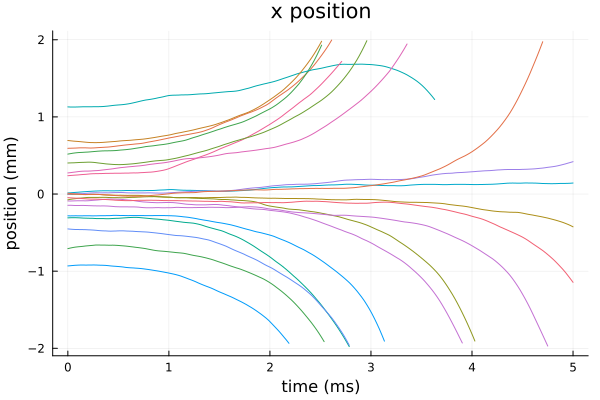

In [8]:
plot_all_trajectories(results2, "x")
plot!()

In [16]:
# using MAT

# saving_dir = "C:\\Users\\halla\\OneDrive\\Desktop\\toy_model_sim"

# file_path = joinpath(saving_dir, "trajectories_2_and_3_freq.mat");

# file = matopen(file_path, "w")

# write(file, "times_2", results2.times)
# write(file, "trajectories_2", results2.z_trajectories)
# write(file, "times_3", results3.times)
# write(file, "trajectories_3", results3.z_trajectories)

# close(file);

┌ Warning: G:\My Drive\github\UnitsToValue\src is not an existing directory, Revise is not watching
└ @ Revise C:\Users\halla\.julia\packages\Revise\bAgL0\src\packagedef.jl:573
┌ Warning: G:\My Drive\github\OpticalBlochEquations\src is not an existing directory, Revise is not watching
└ @ Revise C:\Users\halla\.julia\packages\Revise\bAgL0\src\packagedef.jl:573


In [61]:
bootstrap_size_fit(results,9;iter=100)

(0.07207841433418082, 0.0029348902046640217)

In [60]:
results3 = results;

In [59]:
bootstrap_temperature_fit(results,5;iter=100)

(246.9092084496682, 20.351031924640623)

In [26]:
bootstrap_size_fit(results,5;iter=100)

(0.03945307493387002, 0.0008944483967156512)

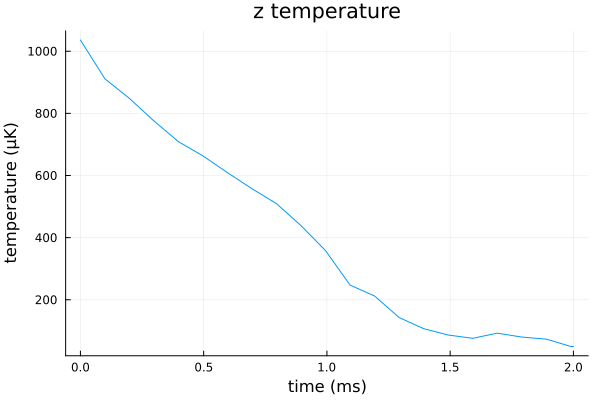

In [77]:
plot_temperature(results, "z")
plot!()

In [7]:
results1 = bootstrap_iteration(results,n_values=100);
plot_all_trajectories(results1, "z")
p1 = plot!(ylim = [-2,2],title="",ylabel="z (mm)")

Progress:  75%|███████████████████████████████          |  ETA: 0:50:34

LoadError: UndefVarError: `results` not defined

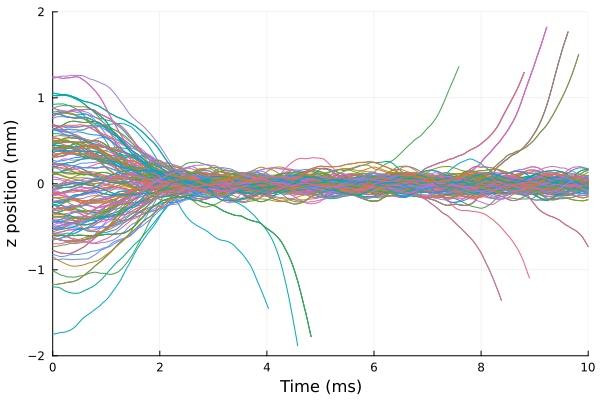

In [25]:
results1 = bootstrap_iteration(results3,n_values=200);
plot_all_trajectories(results1, "z")
p1 = plot!(ylim = [-2,2],title="",xlim=[0,10],xlabel="Time (ms)", ylabel="z position (mm)")

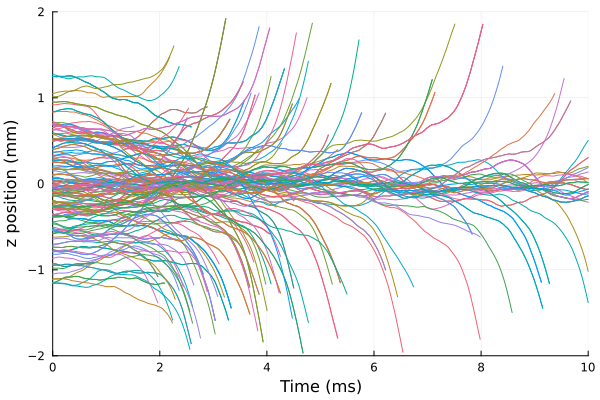

In [62]:
results1 = bootstrap_iteration(results2,n_values=200);
plot_all_trajectories(results1, "z")
p2 = plot!(ylim = [-2,2],title="",ylabel="z position (mm)",xlim=[0,10], xlabel="Time (ms)")

In [ ]:
p1

In [63]:
plot(p1, p2, size=(400,180),xtickfontsize=9,ytickfontsize=9,xguidefontsize=9,yguidefontsize=9,legendfontsize=9,bottom_margin=5Plots.mm,legend=false)
plot!(grid=:off, framestyle=:box,dpi=300, linewidth=1,fontfamily="times",xguidefontcolor=:black, yguidefontcolor=:black)
plot!(x_foreground_color_axis=:black, y_foreground_color_axis=:black, x_foreground_color_border=:black, y_foreground_color_border = :black)
savefig("trajectories_2_3.png")

"G:\\My Drive\\github\\OpticalBlochEquations\\examples\\CaOH_blue_MOT_example\\trajectories_2_3.png"

┌ Warning: G:\My Drive\github\UnitsToValue\src is not an existing directory, Revise is not watching
└ @ Revise C:\Users\halla\.julia\packages\Revise\bAgL0\src\packagedef.jl:573
┌ Warning: G:\My Drive\github\OpticalBlochEquations\src is not an existing directory, Revise is not watching
└ @ Revise C:\Users\halla\.julia\packages\Revise\bAgL0\src\packagedef.jl:573
┌ Warning: G:\My Drive\github\QuantumStates\src is not an existing directory, Revise is not watching
└ @ Revise C:\Users\halla\.julia\packages\Revise\bAgL0\src\packagedef.jl:573


In [34]:
results3 = results;

### Or load an existing simulation result
The example here is a 1000 particle blue MOT simulation for 7.1 ms

In [5]:
results = load_results("",1);

## Plot simulation results

### Plot the molecules' trajectories

Note that molecules that are too far away from the centre are discarded, which is why some trajectories end prematurely.

In [9]:
# plot_all_velocities(results, "z")
# plot!(ylim=[-2,2])

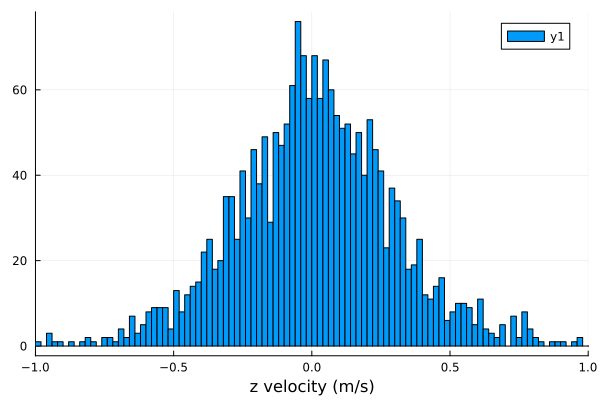

In [87]:
t = 1.1
id_survived = survived_t(results, t)
dt = results.times[1][2]-results.times[1][1]
t_j = Int(floor(t ÷ dt))
    
x_grid = collect(LinRange(-1, 1, 20))
xs = [results.x_velocities[j][t_j] for j in id_survived]
density_x = distribution_to_func(x_grid, xs);
dx = 0.02
bins = Int((maximum(xs)-minimum(xs))÷dx)
histogram(xs, bins=bins,xlim=[-1,1], xlabel="z velocity (m/s)")

### Plot the cloud size over time 
The size here is obtained from the standard deviation of the position distribution.
There is also an option to find the final cloud size by fitting to a Gaussian.

Final size = 0.094 mm

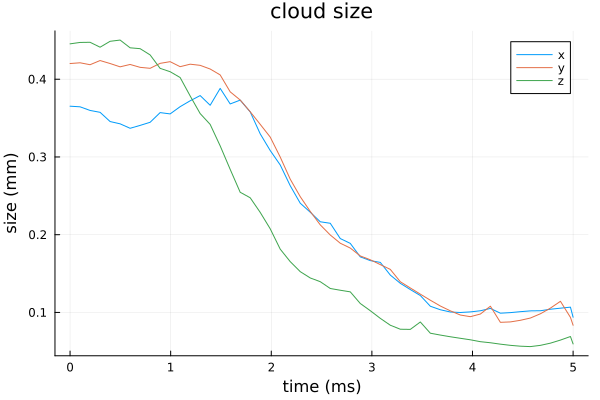

In [14]:
~, σ = plot_size(results,"all")
@printf("Final size = %.3f mm", σ[end])
plot!()

In [15]:
bootstrap_size_fit(results,5,iter=100)

(0.06337209352816585, 0.004092925019390378)

In [17]:
bootstrap_temperature_fit(results,5,iter=100)

(180.44273870496866, 18.03513434600427)

### Plot temperature over time 
Temperatures here are obtained from the standard deviation of the velocity distribution. One could also fit the velocity distribution to a Gaussian.

Temperature = 220.1 uK

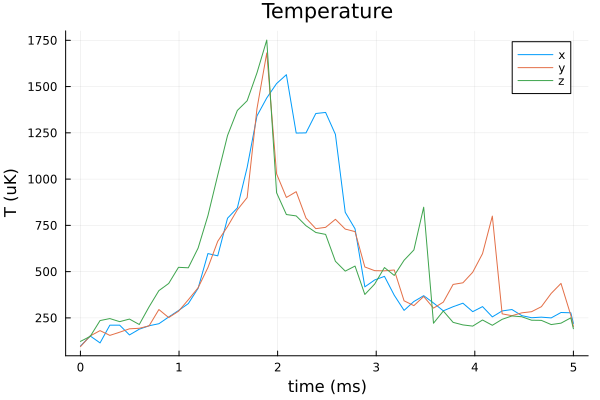

In [16]:
~, T = plot_temperature(results, "all")
@printf("Temperature = %.1f uK", T[end])
plot!()

### Plot the scattering rate of the molecules 
Scattering rate = excited state population * Γ

Average scattering rate = 1.19 MHz

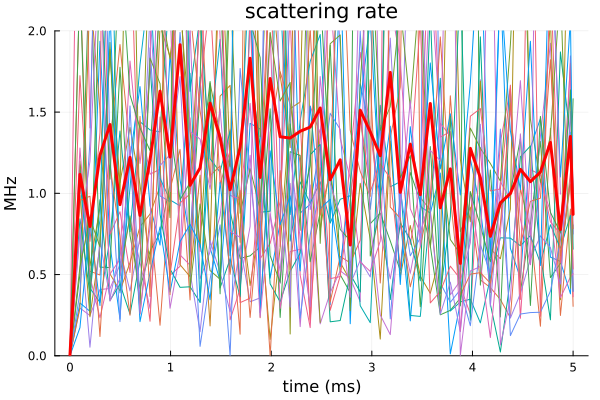

In [12]:
sr = plot_scattering_rate(results)
@printf("Average scattering rate = %.2f MHz", sr)
plot!(ylim=[0,2])

### Simulate camera images
We can also generate "camera images" by taking 2D snapshots (integrated over y direction) of the molecules.

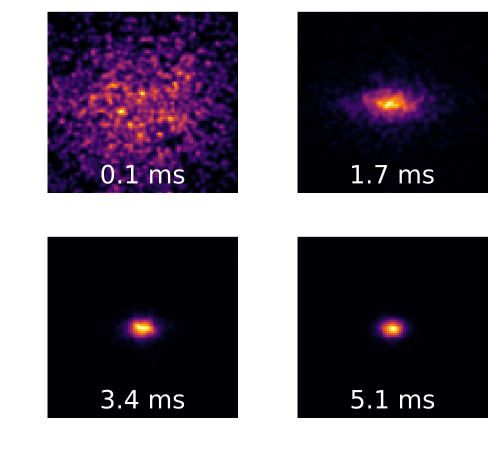

In [32]:
ROI = 0.8  # mm

img_duration = 2.0   # the image will be averaged over this duration
n_pixels = 100

ts = [0.1,1.7,3.4,5.1]
filter = 1.   # Gaussian filtering the image

plots = []
for t in ts
    x, z, grids = take_camera_image(results, -ROI, ROI, n_pixels, t=t, t_img=img_duration, const_scattering=false, noise=0.0, photon_budget=12000)
    imgg = imfilter(grids, Kernel.gaussian(filter))
    p = heatmap(x,z,imgg',legend=:none, xaxis=false, yaxis=false)
    annotate!(0,-ROI*0.8,text(@sprintf("%.1f ms", t),:white,17))
    push!(plots, p)
end

plot(plots[1],plots[2],plots[3],plots[4], size=(500,450))
    
plot!()

In [3]:
function get_Δ_from_exp(voltage, aom1_freq, aom2_freq)
    # return Δ1, Δ2 in MHz
    Δ1 = 52 - 7.4*(5.5-voltage)
    Δ2 = Δ1 + 51.24 - aom1_freq
    Δ4 = Δ1 + 51.24 - aom2_freq
    return Δ1, Δ2, Δ4
end


## Initial condition of the molecule cloud
temp = @with_unit 100e-3 "mK"
diameter = @with_unit 0.6 "mm"
displacement = [0.0, 0.0, 0.0]*1e-3
kick = [0,0, 0.0, 0.0]
 
## Define B field gradient and ramp time
B_gradient = 75; ramp_time = 4e-3

## Laser detunings
detuning_voltage = -0.5
aom1_freq = 53.75
aom2_freq = 52
Δ1, Δ3, Δ4 = get_Δ_from_exp(detuning_voltage, aom1_freq, aom2_freq).*(1e6*2π)
Δ2 = 0.0


## Laser intensities
intensity_voltage = 0.9
power_total = intensity_voltage * 13.1 /2.2*1.3 # mW

p1 = 3.7/(3.7 + 2.8 + 3.5) * power_total
p3 = 2.8/(3.7 + 2.8 + 3.5) * power_total
p4 = 3.5/(3.7 + 2.8 + 3.5) * power_total

s1 = 2 * p1 / (π * 0.5^2) / 3.4
s2 = 0.0
s3 = 2 * p3 / (π * 0.5^2) / 3.4
s4 = 2 * p4 / (π * 0.5^2) / 3.4



blue_MOT_params = MutableNamedTuple(t_start = 0.0, t_end = 1e-4, n_values = 1,
                                pol1_x=σ⁻, pol2_x=σ⁻, pol3_x=σ⁺, pol4_x=σ⁻, 
                                s1=s1, s2=s2, s3=s3, s4=s4,
                                Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4, 

                                B_gradient = B_gradient, 
                                B_ramp_time = ramp_time,
                                Bz_offset = 0.0, By_offset = 0.0, Bx_offset=0.0,

                                temp=temp, diameter=diameter, 
                                displacement=displacement, kick=kick,
                                s_ramp_time = ramp_time,
                                s_ramp_to_factor = 7/9,

                                photon_budget=Inf, dark_lifetime=1/(0.7e6)*Γ, FC_mainline=1,

                                pol_imbalance=0.0, 
                                s_imbalance = (0., 0., -0.), retro_loss=0., 
                                off_center=[0, -0, -0, 0, 0, 0].*1e-3, 
                                pointing_error =[0.0, 0.0, 0.0,0.0,0,0],

                                ODT_intensity = 0*13.3*1e3/(50e-4)^2,
                                ODT_size = (30e-6, 2e-3, 30e-6), 
                                ODT_revolutions = 3,
                                ODT_rmax = 100e-6, # distance of radial motion
                                ODT_tmax = 30e-3, # timescale of radial motion
                                ODT_motion_t_start = 30e-3,
                                ODT_motion_t_stop = 50e-3,

                                dt = 1e-2,

                                diffusion_constant =0.0)
;

In [4]:
prob = make_problem_with_param_diffusion(package, package_A, blue_MOT_params);

In [5]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,
    # DiffEqNoiseProcess,
    Random,
    StatsBase
;

using Distributions

import MutableNamedTuples: MutableNamedTuple
import StructArrays: StructArray, StructVector
import StaticArrays: @SVector, SVector
import LinearAlgebra: norm, ⋅, adjoint!, diag
import LoopVectorization: @turbo
using BenchmarkTools
using Parameters
using LsqFit
import OpticalBlochEquations: extend_operator

import ProgressMeter: Progress, next!



function condition(u,t,integrator)
    p = integrator.p
    integrated_excited_pop = 0.0
    for i ∈ 1:p.n_excited
        integrated_excited_pop += real(u[p.n_states+i])
    end
    
    _condition = integrated_excited_pop - p.time_to_decay
    
    r = 0.0
    for i ∈ 1:3
        r += norm(u[p.n_states + p.n_excited + i])^2
    end
    r = sqrt(r)
    if r >= 3e-3*k # terminate if the particle is more than 3 mm from the centre
       terminate!(integrator) 
    elseif integrator.p.n_scatters > integrator.p.sim_params.photon_budget # also terminate if too many photons have been scattered
        terminate!(integrator)
    end
    return _condition
end



condition (generic function with 1 method)

In [6]:

cb = ContinuousCallback(condition, SE_collapse_pol_diffusion!, nothing, save_positions=(false,false))
                
sol = DifferentialEquations.solve(prob, alg=Euler(), reltol=1e-3, callback=cb, saveat=4000, maxiters=50000000, dt=prob.p.dt)
;

In [11]:
print_matrix(prob.p.P_x)

Real part:
44.35 -0.56 0.0 -0.24 0.2 0.04 0.0 0.7 -0.03 0.34 0.48 -0.15 0.08 0.11 -0.02 -0.17 
-0.56 44.47 0.39 -0.03 0.53 -0.24 -0.26 -0.02 0.04 -0.46 -0.04 0.04 -0.06 0.03 -0.11 0.26 
0.0 0.39 45.0 -0.03 0.07 -0.14 -0.22 -0.0 -0.04 -0.47 -0.15 -0.78 -0.17 -0.26 -0.06 0.08 
-0.24 -0.03 -0.03 43.93 0.19 0.14 0.0 -0.19 0.71 -0.06 -0.2 -0.01 -0.01 -0.01 0.02 -0.31 
0.2 0.53 0.07 0.19 44.49 0.31 0.05 0.18 0.11 0.39 -0.05 0.53 -0.01 -0.03 -0.13 -0.03 
0.04 -0.24 -0.14 0.14 0.31 44.47 -0.33 -0.11 -0.2 -0.26 0.13 -0.26 -0.32 0.05 -0.03 0.05 
0.0 -0.26 -0.22 0.0 0.05 -0.33 44.16 -0.11 0.12 -0.01 0.36 -0.05 0.06 0.13 0.05 0.06 
0.7 -0.02 -0.0 -0.19 0.18 -0.11 -0.11 44.47 -0.14 0.14 0.03 -0.05 -0.06 0.18 -0.03 -0.04 
-0.03 0.04 -0.04 0.71 0.11 -0.2 0.12 -0.14 44.24 0.02 -0.01 0.02 -0.07 0.1 -0.01 -0.1 
0.34 -0.46 -0.47 -0.06 0.39 -0.26 -0.01 0.14 0.02 44.58 -0.15 0.24 -0.07 0.07 -0.09 -0.09 
0.48 -0.04 -0.15 -0.2 -0.05 0.13 0.36 0.03 -0.01 -0.15 44.42 0.05 0.15 0.04 -0.07 -0.16 
-0.15 0.04 -0.7